In [1]:
import numpy as np

data = np.load('all_data.npz', allow_pickle=True)
detokenized_phi4 = data['detokenized']

def find_verification_transitions_improved():
    known_approximate_positions = {
        'verification_A': 2500,
        'verification_B': 4095,
        'verification_C': 2135
    }
    
    def search_in_range(target_pattern, center_idx, search_range=100):
        start_search = max(0, center_idx - search_range)
        end_search = min(len(detokenized_phi4), center_idx + search_range)
        
        pattern_clean = [str(p).strip().lower() for p in target_pattern]
        
        for i in range(start_search, end_search - len(pattern_clean) + 1):
            match_count = 0
            for j, pattern_token in enumerate(pattern_clean):
                actual_token = str(detokenized_phi4[i + j]).strip().lower()
                if (pattern_token == actual_token or 
                    pattern_token in actual_token or 
                    actual_token in pattern_token or
                    (pattern_token == "doesn't" and ("doesn" in actual_token or "t" in actual_token))):
                    match_count += 1
            
            if match_count >= len(pattern_clean) * 0.7:
                return i
        return None
    
    verification_patterns = {
        "verification_A": {
            "description": "Path validity checking",
            "center_pos": known_approximate_positions['verification_A'],
            "verification_patterns": [
                [" That", " doesn", "'t", " work"],
                ["That", "doesn", "'t", "work"],
                [" doesn", "'t", " work", ","],
                [" must", " be", " closed", " loop"]
            ]
        },
        "verification_B": {
            "description": "Route re-checking", 
            "center_pos": known_approximate_positions['verification_B'],
            "verification_patterns": [
                ["I", "will", "re-check"],
                ["I", "will", "re"],
                ["will", "re-check"],
                ["re-check", "0"]
            ]
        },
        "verification_C": {
            "description": "Distance calculation verification",
            "center_pos": known_approximate_positions['verification_C'],
            "verification_patterns": [
                ["Let's", "check", "that"],
                ["Let", "'s", "check"],
                ["check", "that", "route"],
                ["'s", "check", "that"]
            ]
        }
    }
    
    verification_transitions = {}
    
    for verification_id, config in verification_patterns.items():
        verification_start_idx = None
        for pattern in config["verification_patterns"]:
            verification_start_idx = search_in_range(pattern, config['center_pos'])
            if verification_start_idx is not None:
                break
        
        if verification_start_idx is not None:
            before_start = max(0, verification_start_idx - 3)
            before_end = verification_start_idx
            after_start = verification_start_idx  
            after_end = min(len(detokenized_phi4), verification_start_idx + 3)
            
            verification_transitions[verification_id] = {
                'description': config['description'],
                'verification_start_idx': verification_start_idx,
                'before_indices': list(range(before_start, before_end)),
                'after_indices': list(range(after_start, after_end)),
                'before_tokens': [str(detokenized_phi4[i]) for i in range(before_start, before_end)],
                'after_tokens': [str(detokenized_phi4[i]) for i in range(after_start, after_end)],                
                'context_start': max(0, verification_start_idx - 5),
                'context_end': min(len(detokenized_phi4), verification_start_idx + 8)
            }
    
    return verification_transitions

verification_transitions = find_verification_transitions_improved()

if len(verification_transitions) >= 1:
    residual_stream_phi4 = data['residual_stream']
    
    transition_neural_data = {}
    
    for verification_id, info in verification_transitions.items():
        before_indices = info['before_indices']
        after_indices = info['after_indices']
        
        transition_neural_data[verification_id] = {
            'description': info['description'],
            'verification_start_idx': info['verification_start_idx'],
            'before_tokens': info['before_tokens'],
            'after_tokens': info['after_tokens'],
            'before_indices': before_indices,
            'after_indices': after_indices,
            'phi4_before_reprs': residual_stream_phi4[:, before_indices, :],
            'phi4_after_reprs': residual_stream_phi4[:, after_indices, :]
        }


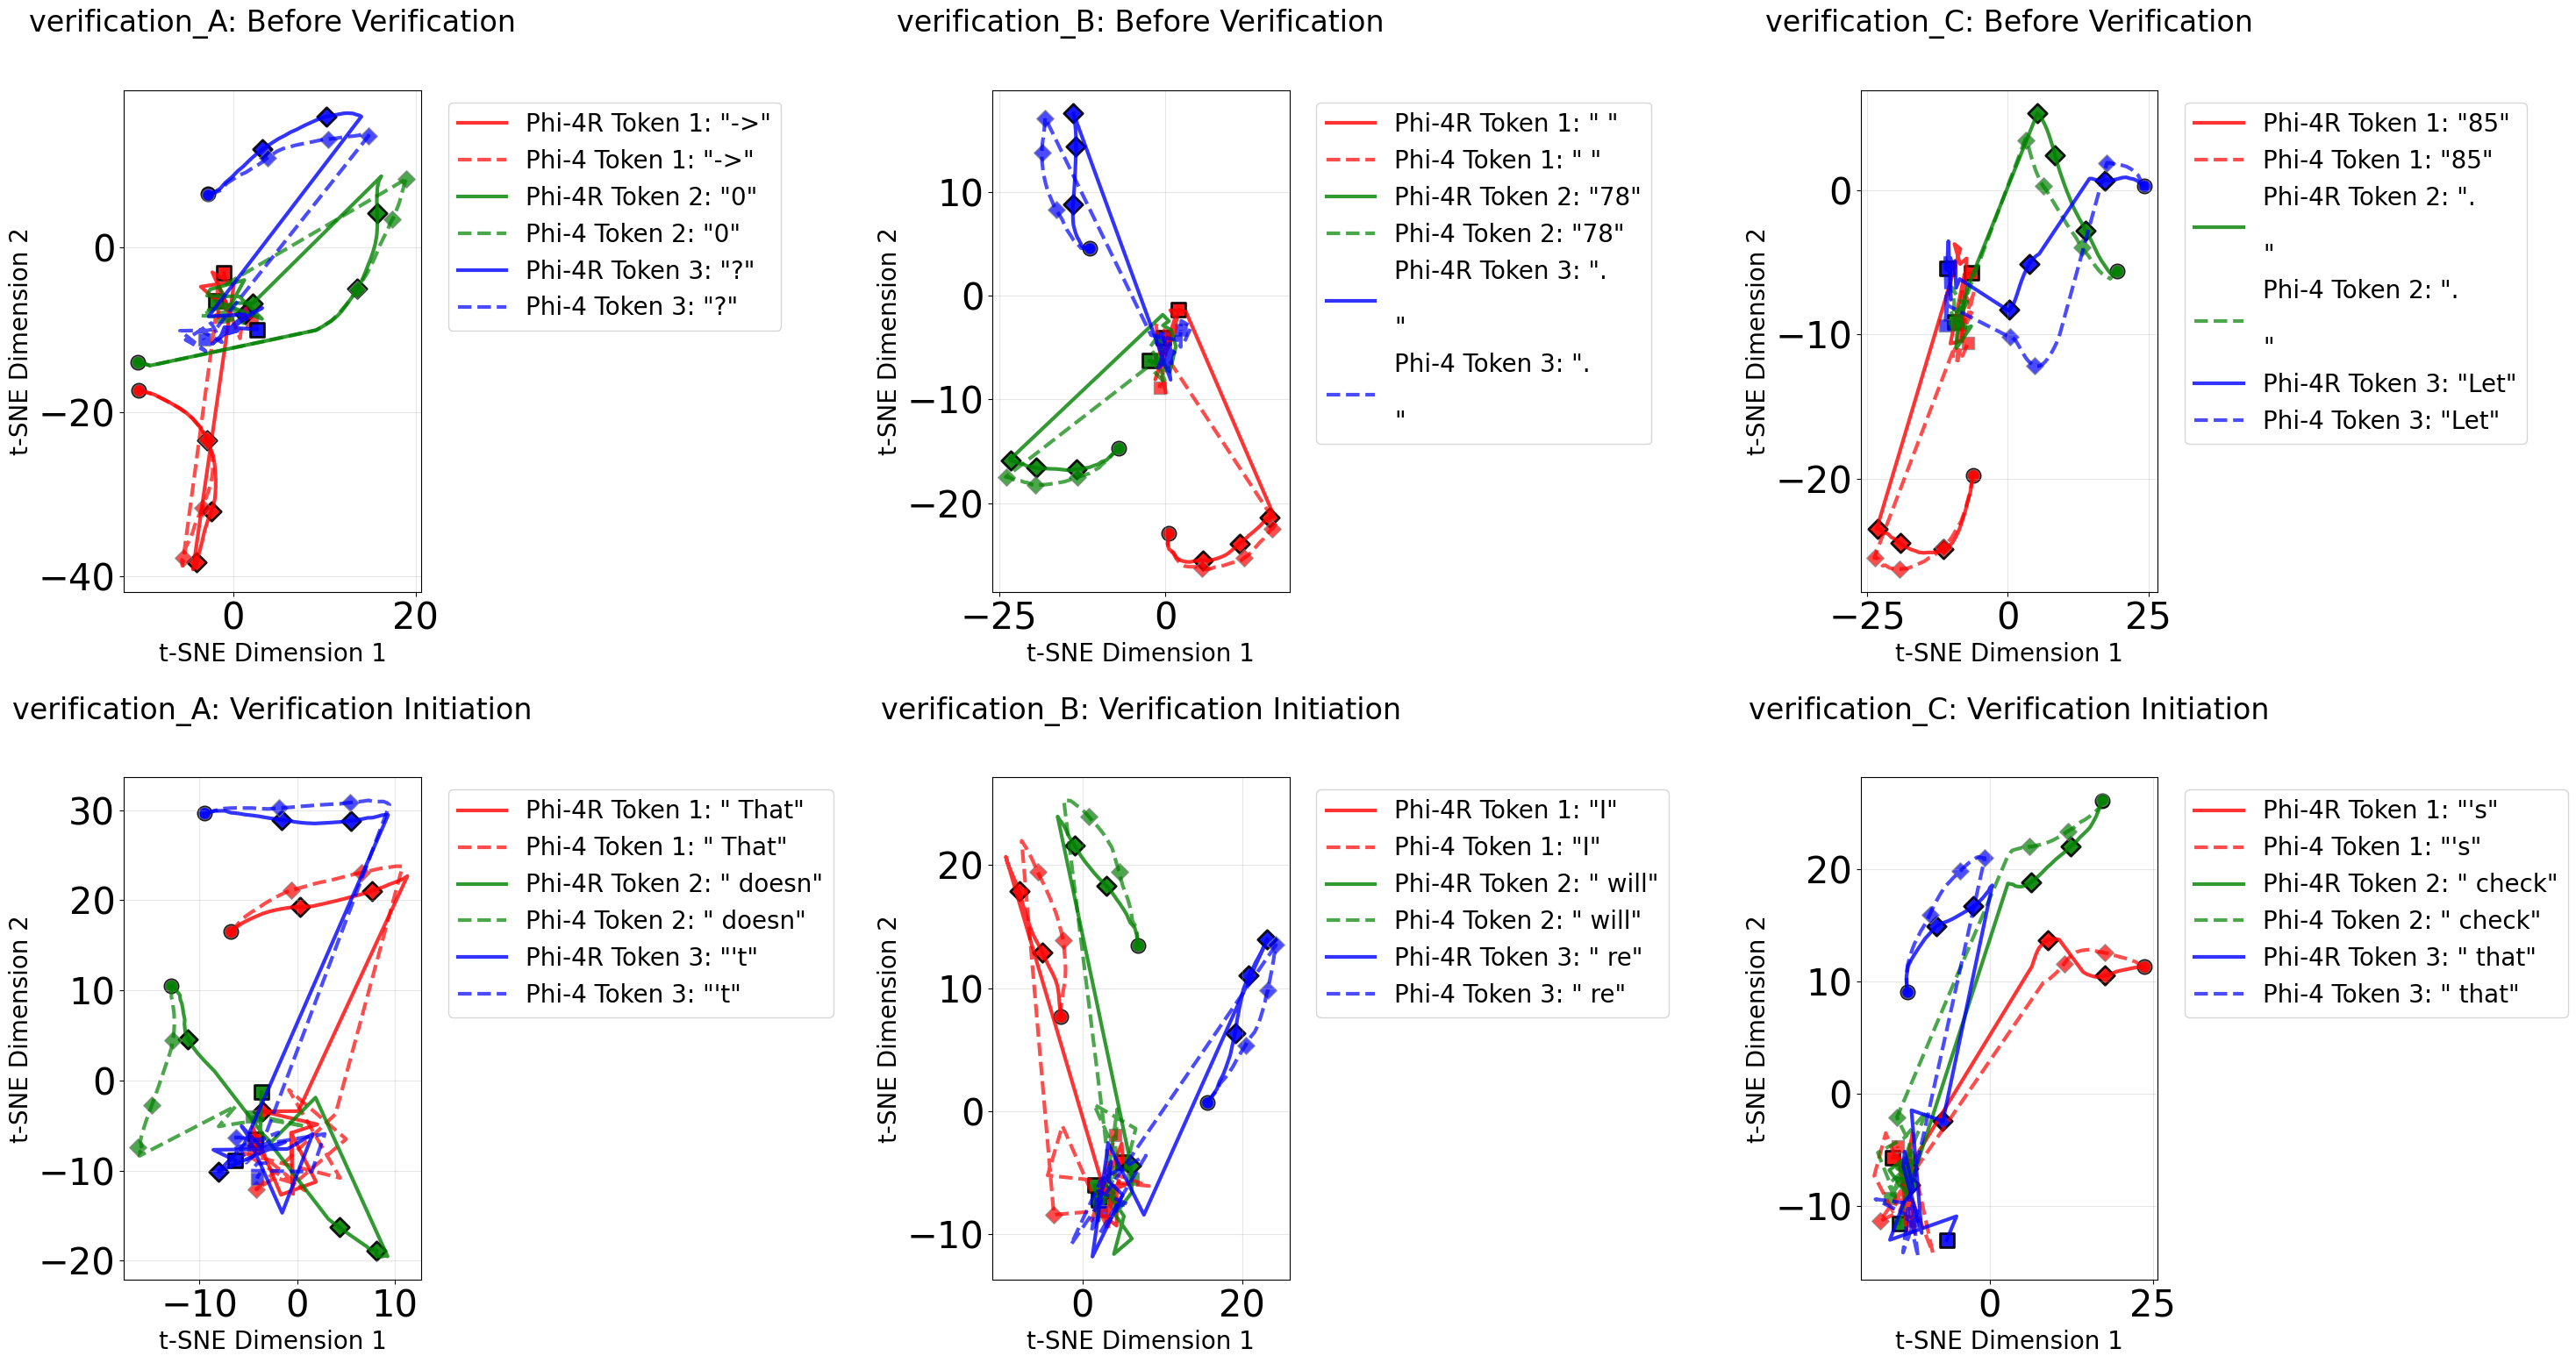

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

data = np.load('all_data.npz', allow_pickle=True)
detokenized_phi4 = data['detokenized']
detokenized_phi4r = data['detokenized_r']
residual_stream_phi4 = data['residual_stream']
residual_stream_phi4r = data['residual_stream_r']

def find_verification_transitions_both_models():
    def search_in_tokenization(detokenized_data, patterns, center_pos, search_range=150):
        for pattern in patterns:
            for i in range(max(0, center_pos - search_range),
                           min(len(detokenized_data), center_pos + search_range)):
                if i + len(pattern) > len(detokenized_data):
                    continue
                match_count = 0
                for j, pattern_token in enumerate(pattern):
                    actual_token = str(detokenized_data[i + j]).strip().lower()
                    pattern_token = str(pattern_token).strip().lower()
                    if (pattern_token == actual_token or 
                        pattern_token in actual_token or 
                        actual_token in pattern_token):
                        match_count += 1
                if match_count >= len(pattern) * 0.8:
                    return i
        return None
    
    verification_configs = {
        "verification_A": {
            "description": "Path validity checking",
            "phi4r_center": 2500,
            "phi4_center": 2450,
            "patterns": [
                [" That", " doesn", "'t", " work"],
                ["That", "doesn", "'t", "work"],
                [" doesn", "'t", " work"],
                ["doesn", "'t", "work"]
            ]
        },
        "verification_B": {
            "description": "Route re-checking",
            "phi4r_center": 4095,
            "phi4_center": 4050,
            "patterns": [
                ["I", "will", "re-check"],
                ["I", "will", "re"],
                ["will", "re-check"],
                ["will", "re"]
            ]
        },
        "verification_C": {
            "description": "Distance calculation verification", 
            "phi4r_center": 2135,
            "phi4_center": 2100,
            "patterns": [
                ["Let's", "check", "that"],
                ["Let", "'s", "check"],
                ["'s", "check", "that"],
                ["check", "that", "route"]
            ]
        }
    }
    
    verification_results = {}
    
    for verification_id, config in verification_configs.items():
        phi4r_pos = search_in_tokenization(
            detokenized_phi4r, config['patterns'], config['phi4r_center']
        )
        phi4_pos = search_in_tokenization(
            detokenized_phi4, config['patterns'], config['phi4_center']
        )
        
        if phi4r_pos is not None and phi4_pos is not None:
            verification_results[verification_id] = {
                'description': config['description'],
                'phi4r_start_idx': phi4r_pos,
                'phi4r_before_indices': list(range(max(0, phi4r_pos - 3), phi4r_pos)),
                'phi4r_after_indices': list(range(phi4r_pos, min(len(detokenized_phi4r), phi4r_pos + 3))),
                'phi4r_before_tokens': [str(detokenized_phi4r[i]) for i in range(max(0, phi4r_pos - 3), phi4r_pos)],
                'phi4r_after_tokens': [str(detokenized_phi4r[i]) for i in range(phi4r_pos, min(len(detokenized_phi4r), phi4r_pos + 3))],
                'phi4_start_idx': phi4_pos,
                'phi4_before_indices': list(range(max(0, phi4_pos - 3), phi4_pos)),
                'phi4_after_indices': list(range(phi4_pos, min(len(detokenized_phi4), phi4_pos + 3))),
                'phi4_before_tokens': [str(detokenized_phi4[i]) for i in range(max(0, phi4_pos - 3), phi4_pos)],
                'phi4_after_tokens': [str(detokenized_phi4[i]) for i in range(phi4_pos, min(len(detokenized_phi4), phi4_pos + 3))],
            }
    
    return verification_results

def extract_comparative_neural_data(verification_results):
    comparative_data = {}
    for verification_id, info in verification_results.items():
        comparative_data[verification_id] = {
            'description': info['description'],
            'phi4r_before_reprs': residual_stream_phi4r[:, info['phi4r_before_indices'], :],
            'phi4r_after_reprs': residual_stream_phi4r[:, info['phi4r_after_indices'], :],
            'phi4r_before_tokens': info['phi4r_before_tokens'],
            'phi4r_after_tokens': info['phi4r_after_tokens'],
            'phi4_before_reprs': residual_stream_phi4[:, info['phi4_before_indices'], :],
            'phi4_after_reprs': residual_stream_phi4[:, info['phi4_after_indices'], :],
            'phi4_before_tokens': info['phi4_before_tokens'],
            'phi4_after_tokens': info['phi4_after_tokens'],
        }
    return comparative_data

def create_comparative_verification_plots(comparative_data):
    n_verifications = len(comparative_data)
    fig, axes = plt.subplots(2, n_verifications, figsize=(10*n_verifications, 16))
    if n_verifications == 1:
        axes = axes.reshape(2, 1)
    
    token_colors = ['red', 'green', 'blue']
    
    for idx, (verification_id, data) in enumerate(comparative_data.items()):
        all_reprs = []
        for token_idx in range(3):
            phi4r_token = data['phi4r_before_reprs'][:, token_idx, :]
            all_reprs.append(phi4r_token)
            phi4_token  = data['phi4_before_reprs'][:, token_idx, :]
            all_reprs.append(phi4_token)
        for token_idx in range(3):
            phi4r_token = data['phi4r_after_reprs'][:, token_idx, :]
            all_reprs.append(phi4r_token)
            phi4_token  = data['phi4_after_reprs'][:, token_idx, :]
            all_reprs.append(phi4_token)
        
        all_reprs = np.vstack(all_reprs)
        all_reprs = normalize(all_reprs, norm='l2', axis=1)

        perplexity = min(30, max(5, all_reprs.shape[0] // 4))
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
        tsne_results = tsne.fit_transform(all_reprs)
        
        ax1 = axes[0, idx]
        ax1.set_title(f'{verification_id}: Before Verification\n', fontsize=24, pad=20)
        
        point_idx = 0
        for token_idx in range(3):
            phi4r_trajectory = tsne_results[point_idx:point_idx+40, :]
            ax1.plot(phi4r_trajectory[:, 0], phi4r_trajectory[:, 1], 
                     color=token_colors[token_idx], linestyle='-', linewidth=3, alpha=0.8,
                     label=f'Phi-4R Token {token_idx+1}: "{data["phi4r_before_tokens"][token_idx]}"')
            key_layers = [0, 10, 20, 30, 39]
            for layer in key_layers:
                ax1.scatter(phi4r_trajectory[layer, 0], phi4r_trajectory[layer, 1], 
                            color=token_colors[token_idx], s=120, alpha=0.9,
                            marker='o' if layer == 0 else ('s' if layer == 39 else 'D'),
                            edgecolor='black', linewidth=2)
            point_idx += 40
            
            phi4_trajectory = tsne_results[point_idx:point_idx+40, :]
            ax1.plot(phi4_trajectory[:, 0], phi4_trajectory[:, 1], 
                     color=token_colors[token_idx], linestyle='--', linewidth=3, alpha=0.7,
                     label=f'Phi-4 Token {token_idx+1}: "{data["phi4_before_tokens"][token_idx]}"')
            for layer in key_layers:
                ax1.scatter(phi4_trajectory[layer, 0], phi4_trajectory[layer, 1], 
                            color=token_colors[token_idx], s=100, alpha=0.7,
                            marker='o' if layer == 0 else ('s' if layer == 39 else 'D'),
                            edgecolor='gray', linewidth=1)
            point_idx += 40
        
        ax1.set_xlabel('t-SNE Dimension 1', fontsize=20)
        ax1.set_ylabel('t-SNE Dimension 2', fontsize=20)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[1, idx]
        ax2.set_title(f'{verification_id}: Verification Initiation\n', fontsize=24, pad=20)
        
        for token_idx in range(3):
            phi4r_trajectory = tsne_results[point_idx:point_idx+40, :]
            ax2.plot(phi4r_trajectory[:, 0], phi4r_trajectory[:, 1], 
                     color=token_colors[token_idx], linestyle='-', linewidth=3, alpha=0.8,
                     label=f'Phi-4R Token {token_idx+1}: "{data["phi4r_after_tokens"][token_idx]}"')
            key_layers = [0, 10, 20, 30, 39]
            for layer in key_layers:
                ax2.scatter(phi4r_trajectory[layer, 0], phi4r_trajectory[layer, 1], 
                            color=token_colors[token_idx], s=120, alpha=0.9,
                            marker='o' if layer == 0 else ('s' if layer == 39 else 'D'),
                            edgecolor='black', linewidth=2)
            point_idx += 40
            
            phi4_trajectory = tsne_results[point_idx:point_idx+40, :]
            ax2.plot(phi4_trajectory[:, 0], phi4_trajectory[:, 1], 
                     color=token_colors[token_idx], linestyle='--', linewidth=3, alpha=0.7,
                     label=f'Phi-4 Token {token_idx+1}: "{data["phi4_after_tokens"][token_idx]}"')
            for layer in key_layers:
                ax2.scatter(phi4_trajectory[layer, 0], phi4_trajectory[layer, 1], 
                            color=token_colors[token_idx], s=100, alpha=0.7,
                            marker='o' if layer == 0 else ('s' if layer == 39 else 'D'),
                            edgecolor='gray', linewidth=1)
            point_idx += 40
        
        ax2.set_xlabel('t-SNE Dimension 1', fontsize=20)
        ax2.set_ylabel('t-SNE Dimension 2', fontsize=20)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

verification_results = find_verification_transitions_both_models()

if len(verification_results) > 0:
    comparative_data = extract_comparative_neural_data(verification_results)
    comparison_fig = create_comparative_verification_plots(comparative_data)
else:
    pass


[found] verification_A at 2571: [' That', ' doesn', "'t"]
[found] verification_B at 4120: ['I', ' will', ' re']
[found] verification_C at 2136: ["'s", ' check', ' that']
[found] trivial_numbers_1 at 1379: ['6', ',', ' ']
[found] trivial_transitions_1 at 1629: ['.', ' From', ' ']
[found] trivial_descriptions_0 at 877: [' ', '42', '\n\n']


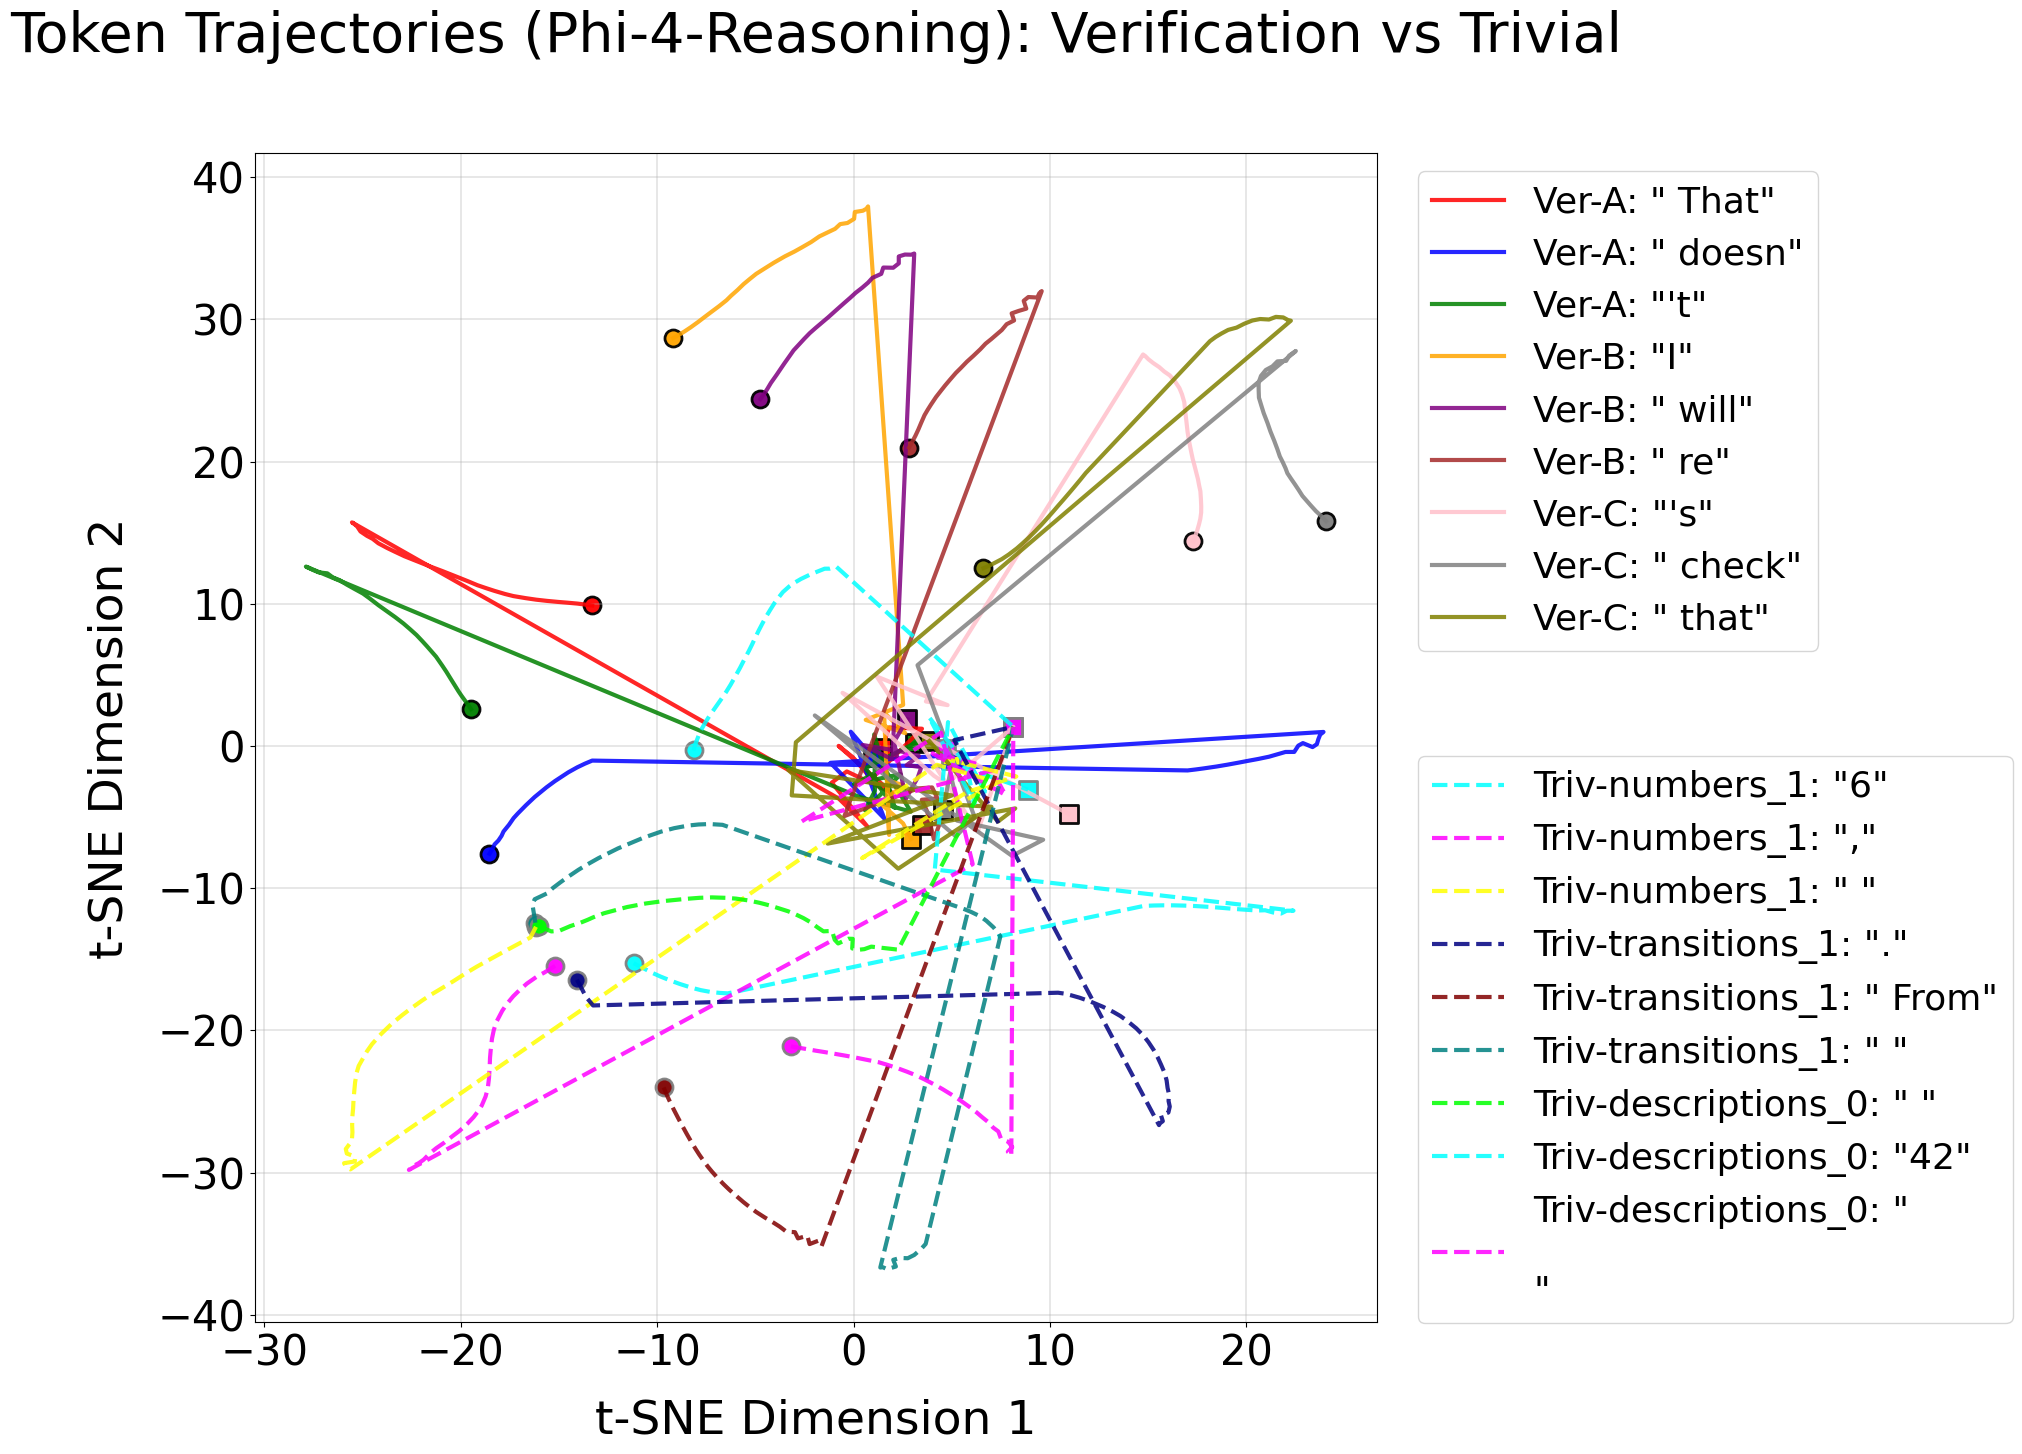

<Figure size 640x480 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize 

mpl.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 40,
    'axes.labelsize': 34,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 26
})

data = np.load('all_data.npz', allow_pickle=True)
detokenized_phi4r = data['detokenized_r']      
residual_stream_phi4r = data['residual_stream_r']

def find_verification_and_trivial_tokens():
    verification_patterns = {
        "verification_A": {
            "center": 2500,
            "patterns": [[" That", " doesn", "'t", " work"]],
            "description": "Path validity checking"
        },
        "verification_B": {
            "center": 4095,
            "patterns": [["I", " will", " re"]],
            "description": "Route re-checking"
        },
        "verification_C": {
            "center": 2135,
            "patterns": [["'s", " check", " that"]],
            "description": "Distance calculation"
        }
    }

    def search_pattern(pattern, center, search_range=100):
        for i in range(max(0, center - search_range),
                       min(len(detokenized_phi4r), center + search_range)):
            if i + len(pattern) > len(detokenized_phi4r):
                continue
            match_count = 0
            for j, expected in enumerate(pattern):
                actual = str(detokenized_phi4r[i + j]).strip().lower()
                expected = str(expected).strip().lower()
                if expected == actual or expected in actual or actual in expected:
                    match_count += 1
            if match_count >= len(pattern) * 0.8:
                return i
        return None

    verification_tokens = {}
    for ver_id, config in verification_patterns.items():
        for pattern in config["patterns"]:
            pos = search_pattern(pattern, config["center"])
            if pos is not None:
                verification_tokens[ver_id] = {
                    'start_idx': pos,
                    'indices': list(range(pos, pos + 3)),  # take 3 tokens
                    'tokens': [str(detokenized_phi4r[i]) for i in range(pos, pos + 3)],
                    'description': config['description'],
                    'type': 'verification'
                }
                print(f"[found] {ver_id} at {pos}: {verification_tokens[ver_id]['tokens']}")
                break

    trivial_patterns = {
        "trivial_numbers": {
            "patterns": [["14", ",", " 4"], ["6", ",", " 2"], ["20", ",", " 2"]],
            "description": "Numbers in calculations",
            "search_ranges": [1000, 1500, 2000]
        },
        "trivial_transitions": {
            "patterns": [[".", " Now", " at"], [".", " From", " 2"], [".", " What", " if"]],
            "description": "Sentence transitions",
            "search_ranges": [1200, 1800, 2300]
        },
        "trivial_descriptions": {
            "patterns": [["City", " 2", ","], ["path", ":", " 0"], ["total", ":", " 20"]],
            "description": "Descriptive text",
            "search_ranges": [800, 1400, 1900]
        }
    }

    trivial_tokens = {}
    for triv_id, config in trivial_patterns.items():
        for i, pattern in enumerate(config["patterns"]):
            search_center = config["search_ranges"][i] if i < len(config["search_ranges"]) else 1500
            pos = search_pattern(pattern, search_center, 200)
            if pos is not None:
                trivial_tokens[f"{triv_id}_{i}"] = {
                    'start_idx': pos,
                    'indices': list(range(pos, pos + 3)),
                    'tokens': [str(detokenized_phi4r[j]) for j in range(pos, pos + 3)],
                    'description': config['description'],
                    'type': 'trivial'
                }
                print(f"[found] {triv_id}_{i} at {pos}: {trivial_tokens[f'{triv_id}_{i}']['tokens']}")
                break

    return verification_tokens, trivial_tokens

def extract_token_representations(token_sets):

    all_token_data = {}
    for token_group, tokens in token_sets.items():
        for token_id, info in tokens.items():
            idxs = info['indices']
            all_token_data[f"{token_group}_{token_id}"] = {
                'indices': idxs,
                'tokens': info['tokens'],
                'description': info['description'],
                'type': info['type'],
                'representations': residual_stream_phi4r[:, idxs, :]  # (L, 3, 5120)
            }
    return all_token_data


def create_single_verification_vs_trivial_plot(all_token_data):

    verification_data = {k: v for k, v in all_token_data.items() if v['type'] == 'verification'}
    trivial_data      = {k: v for k, v in all_token_data.items() if v['type'] == 'trivial'}

    all_colors = [
        'red', 'blue', 'green', 'orange', 'purple', 'brown',
        'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow',
        'navy', 'maroon', 'teal', 'lime', 'aqua', 'fuchsia',
        'silver', 'black', 'crimson', 'indigo', 'violet', 'gold'
    ]

    all_reprs = []
    plot_data = []
    color_idx = 0

    for token_set_id, data in verification_data.items():
        for token_idx in range(3):
            token_reprs = data['representations'][:, token_idx, :]
            all_reprs.append(token_reprs)
            token_text = data['tokens'][token_idx] if token_idx < len(data['tokens']) else f"token_{token_idx}"
            set_name = token_set_id.replace('verification_', '').replace('verification', 'Ver')
            plot_data.append({
                'label': f'Ver-{set_name}: "{token_text}"',
                'type': 'verification',
                'color': all_colors[color_idx % len(all_colors)],
                'linestyle': '-',
                'linewidth': 3,
                'alpha': 0.85,
                'marker_size': 150
            })
            color_idx += 1

    for token_set_id, data in trivial_data.items():
        for token_idx in range(3):
            token_reprs = data['representations'][:, token_idx, :]
            all_reprs.append(token_reprs)
            token_text = data['tokens'][token_idx] if token_idx < len(data['tokens']) else f"token_{token_idx}"
            set_name = token_set_id.replace('trivial_', '').replace('trivial', 'Triv')
            plot_data.append({
                'label': f'Triv-{set_name}: "{token_text}"',
                'type': 'trivial',
                'color': all_colors[color_idx % len(all_colors)],
                'linestyle': '--',
                'linewidth': 3,
                'alpha': 0.85,
                'marker_size': 150
            })
            color_idx += 1

    all_reprs = np.vstack(all_reprs)
    all_reprs = normalize(all_reprs, norm='l2', axis=1)
    norms = np.linalg.norm(all_reprs, axis=1)

    perplexity = min(30, max(5, all_reprs.shape[0] // 4))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    tsne_results = tsne.fit_transform(all_reprs)

    plt.figure(figsize=(20, 15))
    point_idx = 0
    legend_lines = []

    for i, meta in enumerate(plot_data):
        traj = tsne_results[point_idx:point_idx+40, :]
        line = plt.plot(
            traj[:, 0], traj[:, 1],
            color=meta['color'], linestyle=meta['linestyle'],
            linewidth=meta['linewidth'], alpha=meta['alpha'],
            label=meta['label']
        )[0]
        legend_lines.append(line)

        plt.scatter(traj[0, 0], traj[0, 1],
                    color=meta['color'], marker='o',
                    s=meta['marker_size'], alpha=0.95,
                    edgecolor='black' if meta['type'] == 'verification' else 'gray',
                    linewidth=2)
        plt.scatter(traj[-1, 0], traj[-1, 1],
                    color=meta['color'], marker='s',
                    s=meta['marker_size'], alpha=0.95,
                    edgecolor='black' if meta['type'] == 'verification' else 'gray',
                    linewidth=2)

        point_idx += 40

    plt.title('Token Trajectories (Phi-4-Reasoning): Verification vs Trivial\n',
              fontsize=40, pad=28)
    plt.xlabel('t-SNE Dimension 1', fontsize=34, labelpad=18)
    plt.ylabel('t-SNE Dimension 2', fontsize=34, labelpad=18)

    plt.tick_params(axis='both', which='major', labelsize=30)

    half = len(legend_lines) // 2
    leg1 = plt.legend(handles=legend_lines[:half],
                      bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=26)
    plt.gca().add_artist(leg1)
    plt.legend(handles=legend_lines[half:],
               bbox_to_anchor=(1.02, 0.50), loc='upper left', fontsize=26)

    plt.grid(True, alpha=0.3, linewidth=1.4)
    plt.tight_layout()
    plt.show()
    return plt.gcf()

verification_tokens, trivial_tokens = find_verification_and_trivial_tokens()

if len(verification_tokens) > 0 and len(trivial_tokens) > 0:
    all_token_data = extract_token_representations({
        'verification': verification_tokens,
        'trivial': trivial_tokens
    })
    fig = create_single_verification_vs_trivial_plot(all_token_data)
else:
    print("Not enough matches found to plot.")


[found] verification_A at 2572: [' That', ' doesn', "'t"]
[found] verification_B at 4121: ['I', ' will', ' re']
[found] verification_C at 2137: ["'s", ' check', ' that']
[found] trivial_numbers_1 at 1380: ['6', ',', ' ']
[found] trivial_transitions_1 at 1551: ['.', ' From', ' ']
[found] trivial_descriptions_0 at 878: [' ', '42', '\n\n']


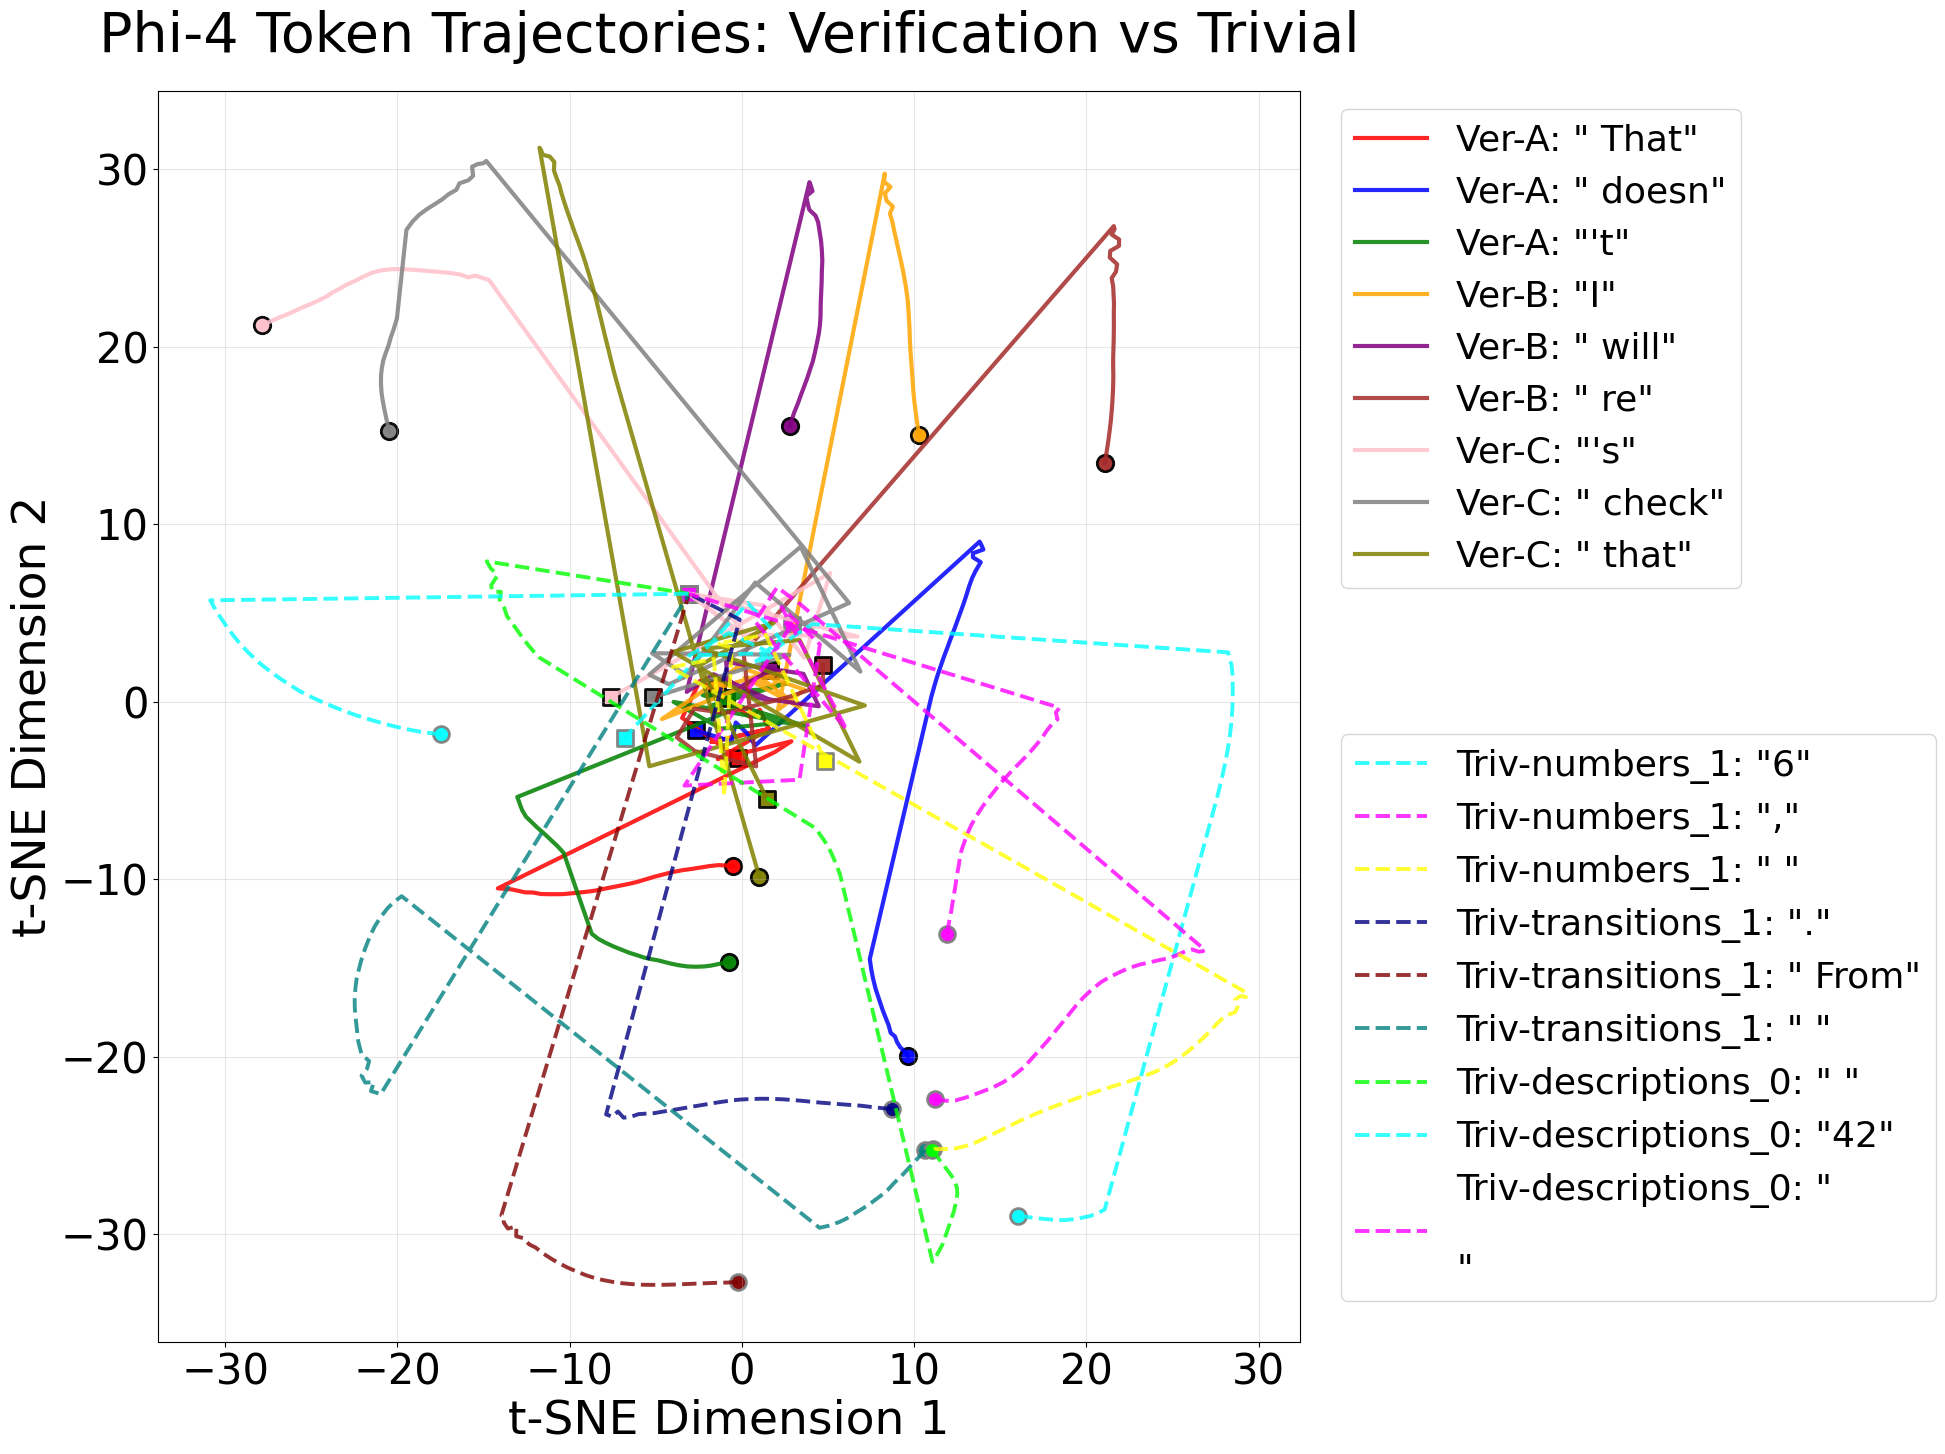

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

mpl.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 40,
    'axes.labelsize': 34,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 26
})

data = np.load('all_data.npz', allow_pickle=True)
detokenized_phi4 = data['detokenized']
residual_stream_phi4 = data['residual_stream']  # shape: (layers, seq_len, 5120)


def find_verification_and_trivial_tokens():

    verification_patterns = {
        "verification_A": {
            "center": 2450,
            "patterns": [[" That", " doesn", "'t", " work"]],
            "description": "Path validity checking"
        },
        "verification_B": {
            "center": 4050,
            "patterns": [["I", " will", " re"]],
            "description": "Route re-checking"
        },
        "verification_C": {
            "center": 2100,
            "patterns": [["'s", " check", " that"]],
            "description": "Distance calculation"
        }
    }

    def search_pattern(pattern, center, search_range=150):
        for i in range(max(0, center - search_range),
                       min(len(detokenized_phi4), center + search_range)):
            if i + len(pattern) > len(detokenized_phi4):
                continue
            match_count = 0
            for j, expected in enumerate(pattern):
                actual = str(detokenized_phi4[i + j]).strip().lower()
                expected = str(expected).strip().lower()
                if expected == actual or expected in actual or actual in expected:
                    match_count += 1
            if match_count >= len(pattern) * 0.8:
                return i
        return None

    verification_tokens = {}
    for ver_id, config in verification_patterns.items():
        for pattern in config["patterns"]:
            pos = search_pattern(pattern, config["center"])
            if pos is not None:
                verification_tokens[ver_id] = {
                    'start_idx': pos,
                    'indices': list(range(pos, pos + 3)),
                    'tokens': [str(detokenized_phi4[i]) for i in range(pos, pos + 3)],
                    'description': config['description'],
                    'type': 'verification'
                }
                print(f"[found] {ver_id} at {pos}: {verification_tokens[ver_id]['tokens']}")
                break

    trivial_patterns = {
        "trivial_numbers": {
            "patterns": [["14", ",", " 4"], ["6", ",", " 2"], ["20", ",", " 2"]],
            "description": "Numbers in calculations",
            "search_ranges": [950, 1450, 1950]
        },
        "trivial_transitions": {
            "patterns": [[".", " Now", " at"], [".", " From", " 2"], [".", " What", " if"]],
            "description": "Sentence transitions",
            "search_ranges": [1150, 1750, 2250]
        },
        "trivial_descriptions": {
            "patterns": [["City", " 2", ","], ["path", ":", " 0"], ["total", ":", " 20"]],
            "description": "Descriptive text",
            "search_ranges": [750, 1350, 1850]
        }
    }

    trivial_tokens = {}
    for triv_id, config in trivial_patterns.items():
        for i, pattern in enumerate(config["patterns"]):
            search_center = config["search_ranges"][i] if i < len(config["search_ranges"]) else 1500
            pos = search_pattern(pattern, search_center, 250)
            if pos is not None:
                trivial_tokens[f"{triv_id}_{i}"] = {
                    'start_idx': pos,
                    'indices': list(range(pos, pos + 3)),
                    'tokens': [str(detokenized_phi4[j]) for j in range(pos, pos + 3)],
                    'description': config['description'],
                    'type': 'trivial'
                }
                print(f"[found] {triv_id}_{i} at {pos}: {trivial_tokens[f'{triv_id}_{i}']['tokens']}")
                break

    return verification_tokens, trivial_tokens


def extract_token_representations(token_sets):

    all_token_data = {}
    for token_group, tokens in token_sets.items():
        for token_id, info in tokens.items():
            indices = info['indices']
            all_token_data[f"{token_group}_{token_id}"] = {
                'indices': indices,
                'tokens': info['tokens'],
                'description': info['description'],
                'type': info['type'],
                'representations': residual_stream_phi4[:, indices, :]  # (L, 3, 5120)
            }
    return all_token_data


def create_single_verification_vs_trivial_plot(all_token_data):


    verification_data = {k: v for k, v in all_token_data.items() if v['type'] == 'verification'}
    trivial_data      = {k: v for k, v in all_token_data.items() if v['type'] == 'trivial'}

    all_colors = [
        'red', 'blue', 'green', 'orange', 'purple', 'brown',
        'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow',
        'navy', 'maroon', 'teal', 'lime', 'aqua', 'fuchsia',
        'silver', 'black', 'crimson', 'indigo', 'violet', 'gold'
    ]

    all_reprs = []
    plot_meta = []
    color_idx = 0

    for token_set_id, data in verification_data.items():
        for token_idx in range(3):
            token_reprs = data['representations'][:, token_idx, :]
            all_reprs.append(token_reprs)
            token_text = data['tokens'][token_idx] if token_idx < len(data['tokens']) else f"token_{token_idx}"
            set_name = token_set_id.replace('verification_', '').replace('verification', 'Ver')
            plot_meta.append({
                'label': f'Ver-{set_name}: "{token_text}"',
                'type': 'verification',
                'color': all_colors[color_idx % len(all_colors)],
                'linestyle': '-',
                'linewidth': 3,
                'alpha': 0.85,
                'marker_size': 140
            })
            color_idx += 1

    for token_set_id, data in trivial_data.items():
        for token_idx in range(3):
            token_reprs = data['representations'][:, token_idx, :]
            all_reprs.append(token_reprs)
            token_text = data['tokens'][token_idx] if token_idx < len(data['tokens']) else f"token_{token_idx}"
            set_name = token_set_id.replace('trivial_', '').replace('trivial', 'Triv')
            plot_meta.append({
                'label': f'Triv-{set_name}: "{token_text}"',
                'type': 'trivial',
                'color': all_colors[color_idx % len(all_colors)],
                'linestyle': '--',
                'linewidth': 2.8,
                'alpha': 0.8,
                'marker_size': 130
            })
            color_idx += 1

    all_reprs = np.vstack(all_reprs)

    all_reprs = normalize(all_reprs, norm='l2', axis=1)
    norms = np.linalg.norm(all_reprs, axis=1)

    perplexity = min(30, max(5, all_reprs.shape[0] // 4))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    tsne_results = tsne.fit_transform(all_reprs)

    plt.figure(figsize=(20, 15))
    point_idx = 0
    legend_handles = []

    for meta in plot_meta:
        traj = tsne_results[point_idx:point_idx+40, :]
        line = plt.plot(
            traj[:, 0], traj[:, 1],
            color=meta['color'], linestyle=meta['linestyle'],
            linewidth=meta['linewidth'], alpha=meta['alpha'],
            label=meta['label']
        )[0]
        legend_handles.append(line)

        plt.scatter(traj[0, 0], traj[0, 1],
                    color=meta['color'], marker='o',
                    s=meta['marker_size'], alpha=0.95,
                    edgecolor='black' if meta['type'] == 'verification' else 'gray',
                    linewidth=2)
        plt.scatter(traj[-1, 0], traj[-1, 1],
                    color=meta['color'], marker='s',
                    s=meta['marker_size'], alpha=0.95,
                    edgecolor='black' if meta['type'] == 'verification' else 'gray',
                    linewidth=2)

        point_idx += 40

    plt.title('Phi-4 Token Trajectories: Verification vs Trivial',
              fontsize=40, pad=28)
    plt.xlabel('t-SNE Dimension 1', fontsize=34)
    plt.ylabel('t-SNE Dimension 2', fontsize=34)

    plt.tick_params(axis='both', which='major', labelsize=30)

    half = len(legend_handles) // 2
    leg1 = plt.legend(handles=legend_handles[:half],
                      bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=26)
    plt.gca().add_artist(leg1)
    plt.legend(handles=legend_handles[half:],
               bbox_to_anchor=(1.02, 0.50), loc='upper left', fontsize=26)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


verification_tokens, trivial_tokens = find_verification_and_trivial_tokens()

if len(verification_tokens) > 0 and len(trivial_tokens) > 0:
    all_token_data = extract_token_representations({
        'verification': verification_tokens,
        'trivial': trivial_tokens
    })
    create_single_verification_vs_trivial_plot(all_token_data)
else:
    print("Not enough matches found to plot.")
